## XAI for Image Data

In [1]:
import torch

import json
import pandas as pd
import numpy as np
import torch.nn as nn

import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

c:\Users\korea\anaconda3\envs\py39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Local PC로 실습하는 경우 실행 x / 단 작업경로를 LGES2023_Sampling_and_XAI으로 맞춰주기
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/LGES2023_Sampling_and_XAI

In [ ]:
!pip install lime

In [ ]:
!pip install shap

## 이미지 및 모델 불러오기(VGG16)

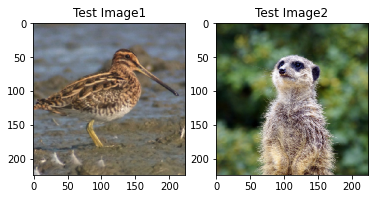

In [2]:
import shap
import torchvision.transforms as tf

# ImageNet Samples 50개
X,y = shap.datasets.imagenet50()

# ImageNet Data의 Class 불러오기
idx2label, cls2label, cls2idx = [], {}, {}
with open(file='./data/imagenet_class_index.json', mode='rt') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}
    
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        scaled_image = image/255.
    scaled_image = (scaled_image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(scaled_image.swapaxes(-1, 1).swapaxes(2, 3)).float()
 
test_imgs = X[[39,41]]
plt.subplot(1,2,1)
plt.imshow(test_imgs[0]/255.)
plt.title('Test Image1')

plt.subplot(1,2,2)
plt.imshow(test_imgs[1]/255.) # BGR -> RGB
plt.title('Test Image2')
plt.show()

In [3]:
from torchvision.models import vgg16, VGG16_Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 사전학습된 모델 호출
model = vgg16(weights=VGG16_Weights.DEFAULT)

model.to(device)
model.eval()
print('load VGG16')

load VGG16


### 모델 예측값 생성

In [4]:
test_imgs_tensor = normalize(test_imgs).to(device)
outputs = model(test_imgs_tensor)
outputs.shape

torch.Size([2, 1000])

In [5]:
# 각 로짓 값을 0~1 사이의 확률값으로 변환
probs = F.softmax(outputs, dim=1)

# 그 중 확률값이 가장 높은 5개를 반환
probs5 = probs.topk(5)
print(probs5)

torch.return_types.topk(
values=tensor([[9.9973e-01, 2.1323e-04, 5.3001e-05, 5.9312e-06, 2.1321e-07],
        [9.2088e-01, 7.8545e-02, 5.4717e-04, 1.2027e-05, 4.9318e-06]],
       device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([[142, 140, 141, 139, 133],
        [299, 298, 336, 360, 356]], device='cuda:0'))


In [6]:
# index와 class를 매칭하여 어떤 class로 예측했는지 확인
array_prob = probs5[0][0].cpu().detach().numpy()
array_class = probs5[1][0].cpu().detach().numpy()
col = ['Probability', 'Index_number', 'Index_name']
pd.DataFrame(tuple((p,c, idx2label[c]) for p, c in zip(array_prob, array_class)), columns=col)

,Probability,Index_number,Index_name
0,9.997275e-01,142,dowitcher
1,2.132310e-04,140,red-backed_sandpiper
2,5.300113e-05,141,redshank
3,5.931179e-06,139,ruddy_turnstone
4,2.132079e-07,133,bittern


In [7]:
# index와 class를 매칭하여 어떤 class로 예측했는지 확인
array_prob = probs5[0][1].cpu().detach().numpy()
array_class = probs5[1][1].cpu().detach().numpy()
col = ['Probability', 'Index_number', 'Index_name']
pd.DataFrame(tuple((p,c, idx2label[c]) for p, c in zip(array_prob, array_class)), columns=col)

,Probability,Index_number,Index_name
0,0.920880,299,meerkat
1,0.078545,298,mongoose
2,0.000547,336,marmot
3,0.000012,360,otter
4,0.000005,356,weasel


## Lime for Image Data

In [8]:
from lime.lime_image import LimeImageExplainer

explainer = LimeImageExplainer()
sample_transform = tf.Compose([
    tf.ToPILImage(),
    tf.Resize((224,224)),
    tf.ToTensor(),
    tf.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# 예측한 클래스 인덱스 값 반환 (최대 로짓을 가지는 클래스의 인덱스 값 반환)
def batch_predict(images:list):
    model.eval()
    
    batch = torch.stack(tuple(sample_transform(i) for i in images), dim=0)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [9]:
test_imgs[0].shape

(224, 224, 3)

In [10]:
# 이미지에 대한 LIME 함수 학습
explanation1 = explainer.explain_instance(np.array(test_imgs[0].astype(np.uint8)),
                                         classifier_fn=batch_predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

explanation2 = explainer.explain_instance(np.array(test_imgs[1].astype(np.uint8)),
                                         classifier_fn=batch_predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

print(explanation1.top_labels)
print(explanation2.top_labels)

100%|██████████| 1000/1000 [00:03<00:00, 258.08it/s]

[142, 140, 141, 139, 133]
[299, 298, 336, 360, 356]


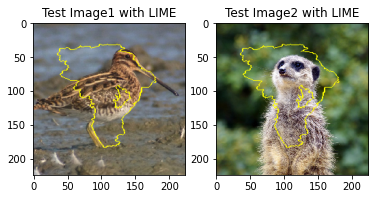

In [11]:
# top 1 class로 예측한 것에 대한 해석
from skimage.segmentation import mark_boundaries

temp1, mask1 = explanation1.get_image_and_mask(explanation1.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp1/255.0, mask1)

temp2, mask2 = explanation2.get_image_and_mask(explanation2.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry2 = mark_boundaries(temp2/255.0, mask1)

plt.subplot(1,2,1)
plt.imshow(img_boundry1)
plt.title('Test Image1 with LIME')

plt.subplot(1,2,2)
plt.imshow(img_boundry2)
plt.title('Test Image2 with LIME')
plt.show()

## SHAP for Image Data

### Shap Value를 추정하는 방법에 따라 여러 함수 존재

### 1. GradientShap -> Integrated Gradients란 방법을 shap으로 확장

논문 : https://arxiv.org/pdf/1703.01365.pdf

### 2. PartitionShap

### 3. DeepShap -> DeepLIFT란 방법을 shap으로 확장. 연산량이 가장 많이 필요. 실습x

논문 : http://proceedings.mlr.press/v70/shrikumar17a

https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html


In [12]:
import time, shap

In [13]:
device = 'cpu'
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

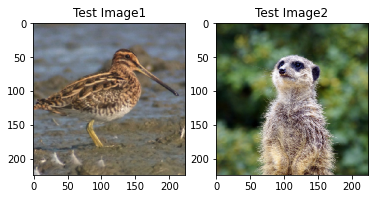

In [14]:
# ImageNet Samples 50개
X,y = shap.datasets.imagenet50()

# ImageNet Data의 Class 불러오기
idx2label, cls2label, cls2idx = [], {}, {}
with open(file='./data/imagenet_class_index.json', mode='rt') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}
    
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        scaled_image = image/255.
    scaled_image = (scaled_image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(scaled_image.swapaxes(-1, 1).swapaxes(2, 3)).float()
 
test_imgs = X[[39,41]]
plt.subplot(1,2,1)
plt.imshow(test_imgs[0]/255.)
plt.title('Test Image1')

plt.subplot(1,2,2)
plt.imshow(test_imgs[1]/255.) # BGR -> RGB
plt.title('Test Image2')
plt.show()

#### 1. GradientShap

In [15]:
explainer = shap.GradientExplainer(model=(model.to(device), model.features[7]),
                                   data=normalize(X).to(device)) # shap value 추론에 사용될 데이터

In [68]:
start = time.time()
shap_values_tensor, indexes = explainer.shap_values(X=normalize(test_imgs).to(device),
                                            ranked_outputs=2, nsamples=50)
indexes = indexes.cpu()
print(f'GradientShap computation time : {time.time()-start:.2f} seconds')

GradientShap computation time : 37.80 seconds


In [69]:
# 이미지 개수 / top-k 예측값에 대한 shap values
print(len(shap_values_tensor), '/' ,shap_values_tensor[0].shape)
# top-k 예측 class
print(indexes)

2 / (2, 128, 112, 112)
tensor([[142, 140],
        [299, 298]])


In [70]:
# get the names for the classes
index_names = np.vectorize(lambda x: class_idx[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values_tensor]
print(shap_values[0].shape)

(2, 112, 112, 128)


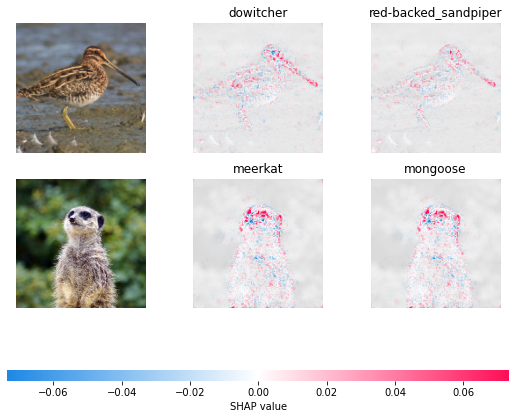

In [75]:
shap.image_plot(shap_values, test_imgs/255., index_names)

### 2. Partition Shap

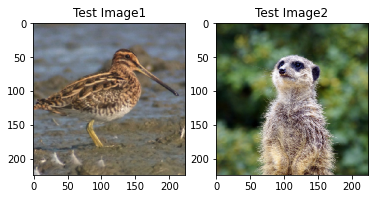

In [80]:
# ImageNet Samples 50개
X,y = shap.datasets.imagenet50()

# ImageNet Data의 Class 불러오기
idx2label, cls2label, cls2idx = [], {}, {}
with open(file='./data/imagenet_class_index.json', mode='rt') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}
    
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        scaled_image = image/255.
    scaled_image = (scaled_image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(scaled_image.swapaxes(-1, 1).swapaxes(2, 3)).float()
 
test_imgs = X[[39,41]]
plt.subplot(1,2,1)
plt.imshow(test_imgs[0]/255.)
plt.title('Test Image1')

plt.subplot(1,2,2)
plt.imshow(test_imgs[1]/255.) # BGR -> RGB
plt.title('Test Image2')
plt.show()

In [87]:
def f(imgs):
    tmp = imgs.copy()
    tmp = normalize(imgs)
    tmp = tmp.to(device)
    return model(tmp)

In [88]:
class_names = [v[1] for v in class_idx.values()]
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

explainer = shap.Explainer(f, masker, output_names=class_names)

In [89]:
start = time.time()
shap_values = explainer(test_imgs, max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])
print(f'PartitionSHAP computation time : {time.time()-start:.2f} seconds')

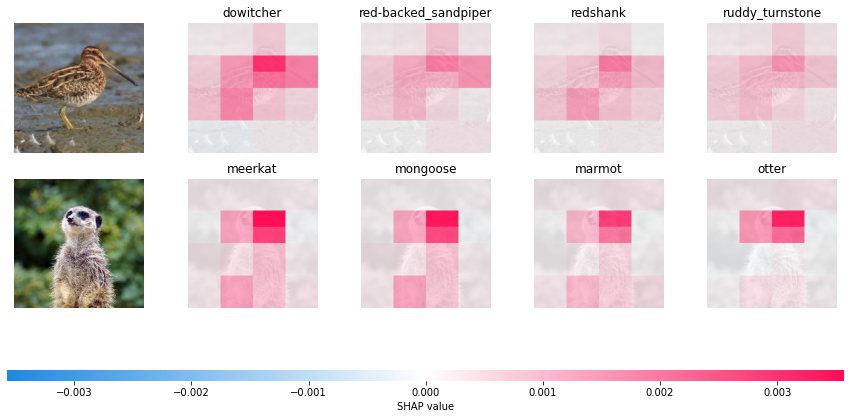

In [93]:
# output with shap values
shap.image_plot(shap_values, test_imgs/255.)

In [94]:
masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

explainer_blur = shap.Explainer(f, masker_blur, output_names=class_names)

# 5000 evaluations to estimate the SHAP values
start = time.time()
shap_values_fine = explainer_blur(test_imgs, max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])
print(f'PartitionSHAP computation time with 5000 eval : {time.time()-start:.2f} seconds')

Partition explainer: 3it [02:02, 61.08s/it]               

PartitionSHAP computation time with 5000 eval : 122.17 seconds


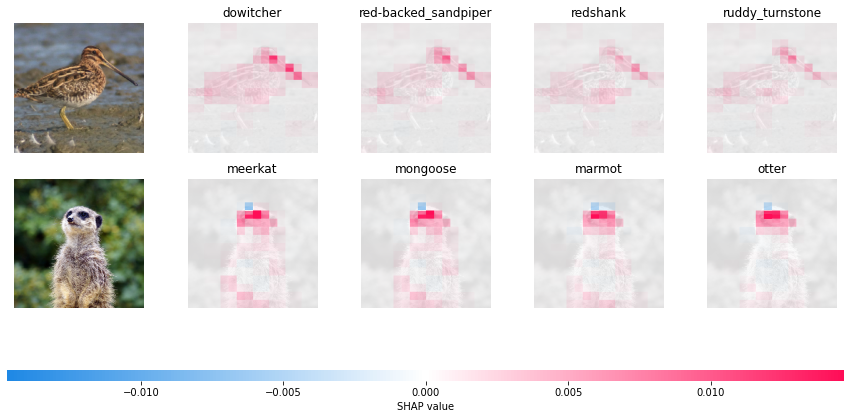

In [97]:
shap.image_plot(shap_values_fine, test_imgs/255.)